In [8]:
import subprocess

# Running the 'which python' command to find out which Python interpreter is being used
result = subprocess.run(["which", "python"], stdout=subprocess.PIPE, text=True)

# Printing the output
print(result.stdout.strip())

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

/Users/leonardpimentel/miniforge3/envs/tf_2.15/bin/python


In [12]:
# Generate data paths with labels

data_dir = Path("../data/kaggle/input/mango-leaf-disease-dataset")
filepaths = []
labels = []

folds = [file for file in os.listdir(data_dir) if file != ".DS_Store"]
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = [file for file in os.listdir(foldpath) if file != ".DS_Store"]
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)

# Splitting data into train-test sets

# train dataframe
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)

# cropped image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(
    sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80])
)
test_steps = ts_length // test_batch_size


# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img


tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=test_batch_size,
)

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = K.applications.efficientnet.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling="max"
)
# base_model.trainable = False

model = Sequential(
    [
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(
            256,
            kernel_regularizer=K.regularizers.l2(l=0.016),
            activity_regularizer=K.regularizers.l1(0.006),
            bias_regularizer=K.regularizers.l1(0.006),
            activation="relu",
        ),
        Dropout(rate=0.45, seed=123),
        Dense(class_count, activation="softmax"),
    ]
)

model.compile(Adamax(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])


ts_length = len(test_df)
test_batch_size = max(
    sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80])
)
test_steps = ts_length // test_batch_size

train_score = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=test_steps, epochs=15, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.predict(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score.history["loss"])
print("Train Accuracy: ", train_score.history["accuracy"])
print("-" * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("-" * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Found 3200 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.
Epoch 1/15
4/4 [==============================] - 65s 11s/step - loss: 10.0037 - accuracy: 0.3281 - val_loss: 12.7112 - val_accuracy: 0.3667
Epoch 2/15
4/4 [==============================] - 32s 10s/step - loss: 8.7009 - accuracy: 0.6875 - val_loss: 11.8971 - val_accuracy: 0.5229
Epoch 3/15
4/4 [==============================] - 33s 10s/step - loss: 8.9638 - accuracy: 0.5781 - val_loss: 11.7045 - val_accuracy: 0.5208
Epoch 4/15
4/4 [==============================] - 32s 10s/step - loss: 8.0672 - accuracy: 0.7969 - val_loss: 10.9563 - val_accuracy: 0.5792
Epoch 5/15
4/4 [==============================] - 30s 9s/step - loss: 8.0962 - accuracy: 0.7812 - val_loss: 10.2544 - val_accuracy: 0.6417
Epoch 6/15
4/4 [==============================] - 31s 9s/step - loss: 7.7424 - accuracy: 0.8750 - val_loss: 9.7184 - va

/Users/leonardpimentel/miniforge3/envs/tf_2.15/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/Users/leonardpimentel/miniforge3/envs/tf_2.15/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


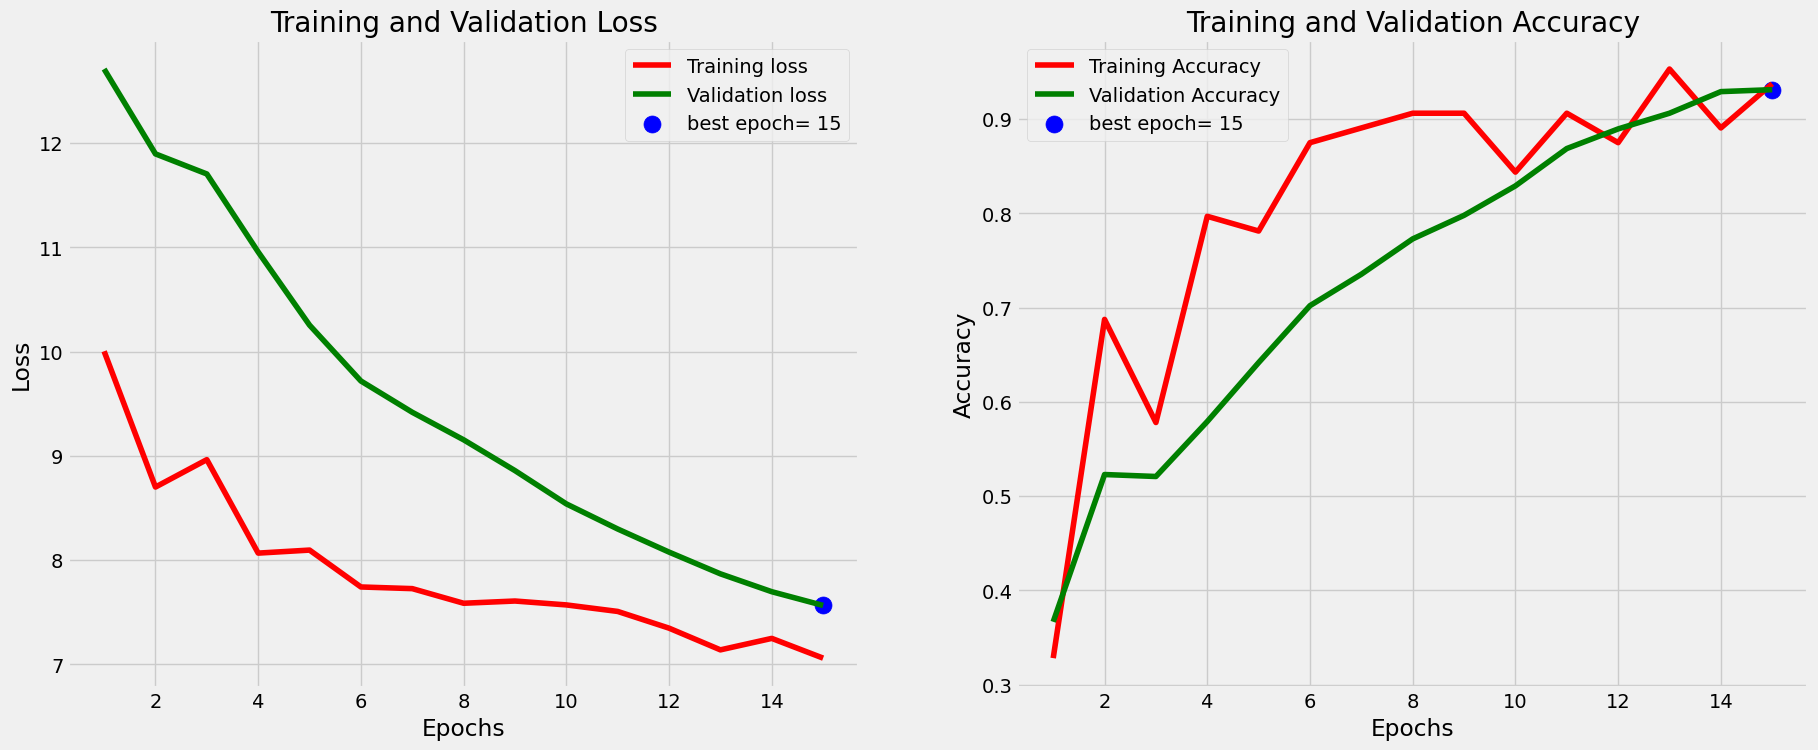

In [14]:
# set an accuracy measurement metrics for the code
# save the history of the measurement metrices after each iteration (epoch)
# return the lowest loss value and the greatest accuracy value after the completion of
# the epochs

# Save the model
model.save("mango_model.h5")

# variables
tr_acc = train_score.history["accuracy"]
tr_loss = train_score.history["loss"]
val_acc = train_score.history["val_accuracy"]
val_loss = train_score.history["val_loss"]
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f"best epoch= {str(index_loss+ 1)}"
acc_label = f"best epoch= {str(index_acc+ 1)}"

# Plot training metrics and log history of training

# history
plt.figure(figsize=(20, 8))
plt.style.use("fivethirtyeight")

# plot two graphs in one space for ease of comparison

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, "r", label="Training loss")
plt.plot(Epochs, val_loss, "g", label="Validation loss")
plt.scatter(index_loss + 1, val_lowest, s=150, c="blue", label=loss_label)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# plot the training and testing accuracy metrices

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, "r", label="Training Accuracy")
plt.plot(Epochs, val_acc, "g", label="Validation Accuracy")
plt.scatter(index_acc + 1, acc_highest, s=150, c="blue", label=acc_label)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout
plt.show()